In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as mplot
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from matplotlib.colors import ListedColormap
import os
import subprocess
import sklearn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score,  precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
 
from sklearn.tree import export_graphviz
import pydotplus
import seaborn as sns

import random
 


from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import keras
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.utils import plot_model
 
from tensorflow.keras import layers, Input
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.metrics import AUC, Precision, Recall, F1Score
from tensorflow.keras.utils import plot_model

import pickle 

import shap
import lime
from lime import lime_tabular
import random

import dalex as dx 


from tabulate import tabulate 


# Define custom metrics
recall = Recall()
precision = Precision()
f1_score = F1Score()
auc = AUC()






In [2]:
dataSetIndex = 4
needToMakePictureOfTrees = 0
''' ---------------------------------------------------------- '''
dataSetFilePath = ""
dataSetName = ""
dataSetResultDirectory = "./"

if(dataSetIndex == 0):
    dataSetFilePath = "./heartDisease/0_statLog_dataSet.csv"
    dataSetName = "SateLog_DataSet"
elif (dataSetIndex == 1):
    dataSetFilePath = "./heartDisease/1_heart_statlog_cleveland_hungary_final.csv"
    dataSetName = "ALL_StateLog_CleveLand_Hungary"
elif (dataSetIndex == 2):
    dataSetFilePath = "./heartDisease/2_cleveland.csv"
    dataSetName = "Cleveland"
elif (dataSetIndex == 3):
    dataSetFilePath = "./heartDisease/3_framingham.csv"
    dataSetName = "framingham"
elif (dataSetIndex == 4):
    dataSetFilePath = "./heartDisease/4_CardiacPrediction.xlsx"
    dataSetName = "CardiacPrediction"
elif (dataSetIndex == 5):
    dataSetFilePath = "./heartDisease/5_CardiacPredictionLessDimensions.xlsx"
    dataSetName = "CardiacPrediction"
elif (dataSetIndex == 6):
    dataSetFilePath = "./heartDisease/6_CardiacPredictionFewDimensions.xlsx"
    dataSetName = "CardiacPrediction"
else:
    dataSetFilePath = ""
    dataSetName = ""

if(dataSetIndex==4 or dataSetIndex==5 or dataSetIndex==6):
    #fileData = pd.read_excel(dataSetFilePath, sheet_name='CoroHeartDis')
    fileData = pd.read_excel(dataSetFilePath)
else:
    fileData = pd.read_csv(dataSetFilePath)

print("Shape of fileData: {}".format(fileData.shape))
print("Column Headings: {}".format(fileData.__dataframe__().column_names()))
print("Number of Records: {}".format(fileData.__dataframe__().num_rows()))


missingValues = fileData.isnull().any().sum()
print(f"\nNumber of Missing Values: {missingValues}")

num_rows_before = fileData.shape[0]
# Remove duplicate records based on all columns
fileData.drop_duplicates(inplace=True)
# Check the number of rows after removing duplicates
num_rows_after = fileData.shape[0]
# Print the number of duplicate records removed
num_duplicates_removed = num_rows_before - num_rows_after
print(f"Number of duplicate records removed: {num_duplicates_removed}")
 
 # Preprocess Steps from the ChatGPT
# 1. Handling Missing Values:
fileData = fileData.dropna()
print("Shape of fileData: {}".format(fileData.shape))              
#fileData.replace({'?': np.nan}).dropna().astype(float)
#fileData = fileData.fillna(0) 

fileData = fileData.fillna(0) 

print("Shape of fileData End: {}".format(fileData.shape))



finalResultTable = [ ['Index', 'Method', 'Accuracy %','Recall %','Precision %','F1 Score','AUC'], ]  

X = fileData.drop(fileData.__dataframe__().column_names()[-1], axis=1)  # Features
Y = fileData[fileData.__dataframe__().column_names()[-1]]  # Labels

columns = fileData.__dataframe__().column_names() 
totalRecords = (fileData.__dataframe__().num_rows())

print("\n")
print("columns of x:: {} \n\n and features of X: {}".format(len(X.columns), X.columns))

dataSetResultDirectory = "./"
dataSetResultDirectory += ("DatasetResults_MLP_with_AttentionLayers_" + dataSetName)
dataSetResultDirectory += "/"
if not os.path.isdir(dataSetResultDirectory):
    os.makedirs(dataSetResultDirectory)

dataSetName += "_{}".format(fileData.shape)



Shape of fileData: (37079, 51)
Column Headings: Index(['SEQN', 'Gender', 'Age', 'Annual-Family-Income',
       'Ratio-Family-Income-Poverty', 'X60-sec-pulse', 'Systolic', 'Diastolic',
       'Weight', 'Height', 'Body-Mass-Index', 'White-Blood-Cells',
       'Lymphocyte', 'Monocyte', 'Eosinophils', 'Basophils', 'Red-Blood-Cells',
       'Hemoglobin', 'Mean-Cell-Vol', 'Mean-Cell-Hgb-Conc.',
       'Mean-cell-Hemoglobin', 'Platelet-count', 'Mean-Platelet-Vol',
       'Segmented-Neutrophils', 'Hematocrit', 'Red-Cell-Distribution-Width',
       'Albumin', 'ALP', 'AST', 'ALT', 'Cholesterol', 'Creatinine', 'Glucose',
       'GGT', 'Iron', 'LDH', 'Phosphorus', 'Bilirubin', 'Protein', 'Uric.Acid',
       'Triglycerides', 'Total-Cholesterol', 'HDL', 'Glycohemoglobin',
       'Vigorous-work', 'Moderate-work', 'Health-Insurance', 'Diabetes',
       'Blood-Rel-Diabetes', 'Blood-Rel-Stroke', 'CoronaryHeartDisease'],
      dtype='object')
Number of Records: 37079

Number of Missing Values: 0
Number o

Target Column Name: CoronaryHeartDisease


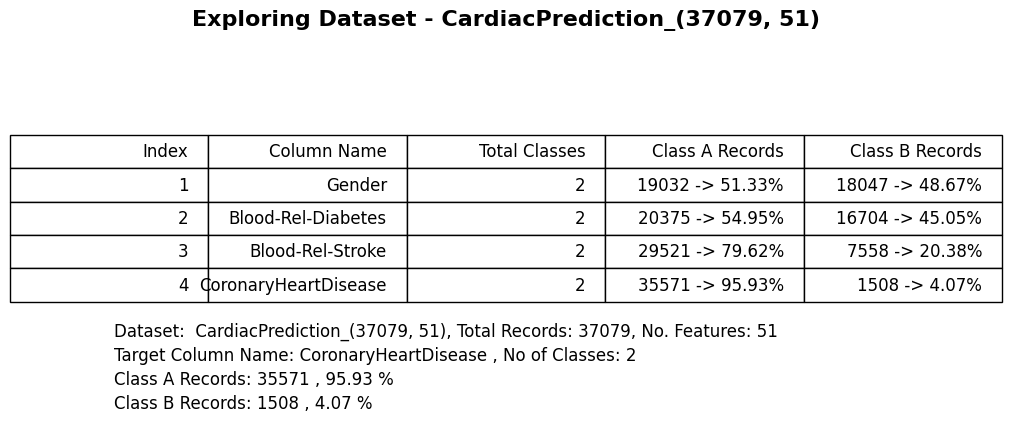

In [3]:
columns = fileData.__dataframe__().column_names() 
totalRecords = (fileData.__dataframe__().num_rows())
columnsForGraph = []
columnsForGraph.clear()
tableDataRow = []
for column in columns:
    singleColumnCount = fileData[column].value_counts()
    if(len(singleColumnCount) < 3):
        #print('Column Name:{} -> total records:{}'.format(column, totalRecords ) )
        #print('Number of classes:', len(singleColumnCount))
        #print('Class distribution:')
        #print(singleColumnCount)
        #print("np Array: {}".format(np.array(singleColumnCount)))
        #print("index: 0: {} -> {} %".format(np.array(singleColumnCount)[0], (np.array(singleColumnCount)[0] /totalRecords) * 100))
        #print("index: 1: {} -> {} %".format(np.array(singleColumnCount)[1], ( np.array(singleColumnCount)[1] /totalRecords) * 100))  
        #print('---------------------------------------------------------------')
        columnsForGraph.append(column)
 

tableDataRow = [
    ['Index', 'Column Name', 'Total Classes','Class A Records','Class B Records'],
    
]

indexx = 1
for column in columnsForGraph:
    singleColumnCount = fileData[column].value_counts()
    singleRowInTable = [] 
    singleRowInTable.append(indexx)
    singleRowInTable.append(column)
    singleRowInTable.append(len(singleColumnCount))
    cellDataString = "{} -> {:.2f}%".format(np.array(singleColumnCount)[0], (np.array(singleColumnCount)[0] /totalRecords) * 100)
    singleRowInTable.append((cellDataString)) 
    cellDataString = "{} -> {:.2f}%".format(np.array(singleColumnCount)[1], (np.array(singleColumnCount)[1] /totalRecords) * 100)
    singleRowInTable.append((cellDataString)) 
    indexx += 1
    tableDataRow.append(singleRowInTable) 

# Create the figure and axes
fig, ax = mplot.subplots() 
table = mplot.table(cellText=tableDataRow, loc='center') 

table.auto_set_font_size(False)
table.set_fontsize(12) 
table.scale(2.0, 2.0) 
print("Target Column Name: {}".format(columns[-1]))


dataSetString = "Dataset:  {}, Total Records: {}, No. Features: {}".format(dataSetName, totalRecords, fileData.__dataframe__().num_columns())
target ="Target Column Name: {} , No of Classes: {}".format(columns[-1], len(fileData[columns[-1]].value_counts()))
distributionOfTargetClassA ="Class A Records: {} , {:.2f} %".format(np.array(fileData[columns[-1]].value_counts())[0], (np.array(fileData[columns[-1]].value_counts())[0] /totalRecords) * 100)
distributionOfTargetClassB ="Class B Records: {} , {:.2f} %".format(np.array(fileData[columns[-1]].value_counts())[1], (np.array(fileData[columns[-1]].value_counts())[1] /totalRecords) * 100)

fig.text(-0.1, +0.25,  dataSetString, horizontalalignment='left', wrap=False , fontsize=12 )  
fig.text(-0.1, +0.20,  target, horizontalalignment='left', wrap=False  , fontsize=12 )   
fig.text(-0.1, 0.15,  distributionOfTargetClassA, horizontalalignment='left', wrap=False , fontsize=12  )   
fig.text(-0.1, 0.10,  distributionOfTargetClassB, horizontalalignment='left', wrap=False  , fontsize=12 )   
 
 
mplot.axis('off')
mplot.title(f'Exploring Dataset - {dataSetName}' ,fontsize=16, fontweight='bold') 

picturePath = "{}1.DataSet_analysis_{}.png".format(dataSetResultDirectory, dataSetName)
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
#mplot.savefig('DataSet_analysis.png', dpi=300)
mplot.show()
mplot.close()
 

In [4]:
print("Shape of fileData: {} , target Len:{}".format(fileData.shape, len(Y)))
print("X: {} , Y:{}".format(X.shape, Y.shape))
#print("\n\nX: head:: \n{}".format(X.head()))
#print("\n\nY: head::\n {}".format(Y.head()))

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
 

print("Target Column Name:: {} \n".format(fileData.__dataframe__().column_names()[-1]))


rus = RandomUnderSampler(random_state=42)
smote = SMOTE(random_state=42)

'''
# Undersample the majority class
X_train, y_train = rus.fit_resample(X_train, y_train)
X_test, y_test = rus.fit_resample(X_test, y_test)
'''

# Oversample the minority class using SMOTE
X_train, y_train = smote.fit_resample(X_train, y_train)
#X_test, y_test = rus.fit_resample(X_test, y_test)
X_test, y_test = smote.fit_resample(X_test, y_test) 


scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



print("\n X Train: Shape:: {}".format(X_train.shape))
print(" X Test: Shape:: {}".format(X_test.shape))  
 
 
positiveClass =  0
negativeClass = 0
for i in y_train:
    if(i == 0):
        negativeClass += 1
    if(i == 1):
        positiveClass += 1
print("Train DataSet Positive Class Records:: {}".format(positiveClass)) 
print("Train DataSet Negative Class Records:: {}".format(negativeClass)) 
print("Train DataSet Total Records:: {}".format(positiveClass + negativeClass)) 

print("\n\n") 


positiveClass =  0
negativeClass = 0
for i in y_test:
    if(i == 0):
        negativeClass += 1
    if(i == 1):
        positiveClass += 1
print("Test DataSet Positive Class Records:: {}".format(positiveClass)) 
print("Test DataSet Negative Class Records:: {}".format(negativeClass)) 
print("Test DataSet Total Records:: {}".format(positiveClass + negativeClass)) 



Shape of fileData: (37079, 51) , target Len:37079
X: (37079, 50) , Y:(37079,)
Target Column Name:: CoronaryHeartDisease 



Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  File "c:\Users\Mubashir Iqbal\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")



 X Train: Shape:: (56914, 50)
 X Test: Shape:: (14228, 50)
Train DataSet Positive Class Records:: 28457
Train DataSet Negative Class Records:: 28457
Train DataSet Total Records:: 56914



Test DataSet Positive Class Records:: 7114
Test DataSet Negative Class Records:: 7114
Test DataSet Total Records:: 14228


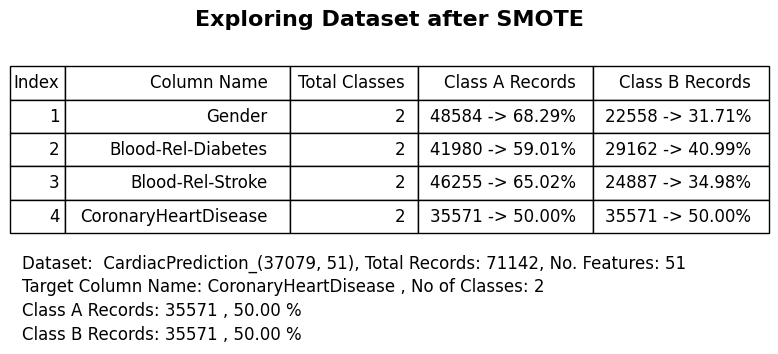

In [5]:

columnsForGraph = []
columnsForGraph.clear()
tableDataRow = []


# Concatenate feature and target data for both training and testing sets
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)
df_combined = pd.concat([df_train, df_test], axis=0, ignore_index=True)

columns = df_combined.__dataframe__().column_names() 
totalRecords = (df_combined.__dataframe__().num_rows())
for column in columns:
    singleColumnCount = df_combined[column].value_counts()
    if(len(singleColumnCount) < 3):
        #print('Column Name:{} -> total records:{}'.format(column, totalRecords ) )
        #print('Number of classes:', len(singleColumnCount))
        #print('Class distribution:')
        #print(singleColumnCount)
        #print("np Array: {}".format(np.array(singleColumnCount)))
        #print("index: 0: {} -> {} %".format(np.array(singleColumnCount)[0], (np.array(singleColumnCount)[0] /totalRecords) * 100))
        #print("index: 1: {} -> {} %".format(np.array(singleColumnCount)[1], ( np.array(singleColumnCount)[1] /totalRecords) * 100))  
        #print('---------------------------------------------------------------')
        columnsForGraph.append(column)
 
tableDataRow = [ ['Index', 'Column Name', 'Total Classes','Class A Records','Class B Records'], ]

indexx = 1
for column in columnsForGraph:
    singleColumnCount = df_combined[column].value_counts()
    singleRowInTable = [] 
    singleRowInTable.append(indexx)
    singleRowInTable.append(column)
    singleRowInTable.append(len(singleColumnCount))
    cellDataString = "{} -> {:.2f}%".format(np.array(singleColumnCount)[0], (np.array(singleColumnCount)[0] /totalRecords) * 100)
    singleRowInTable.append((cellDataString)) 
    cellDataString = "{} -> {:.2f}%".format(np.array(singleColumnCount)[1], (np.array(singleColumnCount)[1] /totalRecords) * 100)
    singleRowInTable.append((cellDataString)) 
    indexx += 1
    tableDataRow.append(singleRowInTable) 

 
# Determine the number of rows in the table (excluding the header)
num_rows = len(tableDataRow) + 1
# Calculate the desired figure size based on the number of rows
fig_width = 6  # Set the desired width of the figure
fig_height = num_rows * 0.5  # Adjust the scaling factor to control the height

fig, ax = mplot.subplots(figsize=(fig_width, fig_height)) 
table = mplot.table(cellText=tableDataRow, loc='center') 

table.auto_set_column_width(col=list(range(len(tableDataRow[0]))))

table.auto_set_font_size(False)
table.set_fontsize(12) 
table.scale(2.0, 2.0) 

dataSetString = "Dataset:  {}, Total Records: {}, No. Features: {}".format(dataSetName, totalRecords, df_combined.__dataframe__().num_columns())
target ="Target Column Name: {} , No of Classes: {}".format(columns[-1], len(df_combined[columns[-1]].value_counts()))
distributionOfTargetClassA ="Class A Records: {} , {:.2f} %".format(np.array(df_combined[columns[-1]].value_counts())[0], (np.array(df_combined[columns[-1]].value_counts())[0] /totalRecords) * 100)
distributionOfTargetClassB ="Class B Records: {} , {:.2f} %".format(np.array(df_combined[columns[-1]].value_counts())[1], (np.array(df_combined[columns[-1]].value_counts())[1] /totalRecords) * 100)

fig.text(-0.1, +0.10,  dataSetString, horizontalalignment='left', wrap=False , fontsize=12 )  
fig.text(-0.1, +0.02,  target, horizontalalignment='left', wrap=False  , fontsize=12 )   
fig.text(-0.1, -0.06,  distributionOfTargetClassA, horizontalalignment='left', wrap=False , fontsize=12  )   
fig.text(-0.1, -0.14,  distributionOfTargetClassB, horizontalalignment='left', wrap=False  , fontsize=12 )   

remarks = "You need to distribute the target class in equal number of records in training-set."
#fig.text(-0.2, -0.15,  remarks, horizontalalignment='left', wrap=True ,fontsize=12, fontweight='bold' )   
 
mplot.axis('off')
mplot.title(f'Exploring Dataset after SMOTE' ,fontsize=16, fontweight='bold') 
picturePath = "{}02.DataSet_analysis_After_dataAugmentation_{}.png".format(dataSetResultDirectory, dataSetName)
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
#mplot.savefig(picturePath,  dpi=300 )
mplot.show()
mplot.close()

In [6]:
def makeCorrelationPic(correlationMatrix, numberOfTopFeatures, targetColumnName):     
    correlation_values = correlationMatrix.abs()
    sorted_correlation = correlation_values.unstack().sort_values(ascending=False)
    sorted_correlation = sorted_correlation[sorted_correlation != 1.0]

    num_features = numberOfTopFeatures  # Number of top features to display
    top_features = sorted_correlation.head(num_features)
    print("Top", num_features, "features based on correlation:")
    print(top_features)
 
    top_features = correlationMatrix.abs().nlargest(numberOfTopFeatures, targetColumnName)[targetColumnName].index
    top_correlation_matrix = correlationMatrix.loc[top_features, top_features]

    mplot.figure(figsize=(10, 8))
    sns.heatmap(top_correlation_matrix, annot=True, cmap='coolwarm')
    # Set the title of the plot
    mplot.title('Correlation Heatmap ({})'.format(dataSetName))
    
    picturePath = "Correlation_Matrix_DateSetName_{}.png".format(dataSetName)
    mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
    mplot.show()
    mplot.close()

def makeConfusionMatrixPic(method, dataSet, classifierObj , X_test, y_test, predicted_Y):
    display = ConfusionMatrixDisplay.from_estimator(classifierObj, X_test, y_test, display_labels=['Healthy', "Heart Disease"], cmap=mplot.cm.Blues) #, normalize="true"
    display.ax_.set_title("Confusion Matrix ({} Model)".format(method))
    ax_.set_xlabel('\nPredicted Values')
    ax_.set_ylabel('Actual Values ')


    accuracyString ="Accuracy {}: {:.2f}".format(method, accuracy_score(y_test, predicted_Y)*100.0 ) 
    recallString =  'Recall {}: {:.2f}'.format(method, recall_score(y_test, predicted_Y) * 100.0)
    precisionString = 'Precision {}: {:.2f}'.format(method, precision_score(y_test, predicted_Y) * 100.0) 
    dataSetString = "Dataset: {}".format(dataSet)

    
    if(classifierObj.n_features_in_ > 10):
        featureListString = 'Total Features: {}'.format(classifierObj.n_features_in_) 
    else:
        featureListString = 'Features: {}'.format(classifierObj.feature_names_in_) 
    
    display.figure_.text(0.010, -0.05,  accuracyString, horizontalalignment='left', wrap=False )  
    display.figure_.text(0.010, -0.09,  recallString, horizontalalignment='left', wrap=False )      
    display.figure_.text(0.010, -0.13,  precisionString, horizontalalignment='left', wrap=False ) 
    display.figure_.text(0.010, -0.17,  dataSetString, horizontalalignment='left', wrap=False ) 
    display.figure_.text(0.010, -0.28,  featureListString, horizontalalignment='left', wrap=False ) 
 
    picturePath = "{}Confusion_Matrix_{}_{}.png".format(dataSetResultDirectory, method, dataSetName)
    mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
    #print("{} Confusion Matrix saved:: path: {}".format(method, picturePath))
    #os.startfile(picturePath)
    mplot.show()
    mplot.close()


In [7]:
X_train_normalized = tf.keras.utils.normalize(X_train, axis=1)
X_test_normalized = tf.keras.utils.normalize(X_test, axis=1)

scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.fit_transform(X_test) 
# Our vectorized labels

X_train_f32 = np.asarray(X_train).astype(np.float32)  #.astype('float32').reshape((-1,1))
X_test_f32 = np.asarray(X_test).astype(np.float32)

#y_train_scaler = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test_scaler = np.asarray(y_test).astype('float32').reshape((-1,1))

 

# Separate features and target variable
features = X_train_scaler # data.iloc[:, :-1]
target = np.asarray(y_train).astype('float64').reshape((-1,1))  #data['CoronaryHeartDisease']
 
 

print("X_train shape: {}   and dType: {}".format(X_train.shape, len(X_train.columns)))
print("X_train_scaler shape: {}   and dType: {}".format(X_train_scaler.shape, X_train_scaler.dtype))
print("X_test_scaler shape: {}   and dType: {}".format(X_test_scaler.shape, X_test_scaler.dtype)) 


print("y_train shape: {}   and dType: {}".format(y_train.shape, y_train.dtype))  
print("y_test_scaler shape: {}   and dType: {}".format(y_test_scaler.shape, y_test_scaler.dtype))  


print("features shape: {}   and dType: {}".format(features.shape, features.dtype))
print("target shape: {}   and dType: {}".format(target.shape, target.dtype)) 

X_train shape: (56914, 50)   and dType: 50
X_train_scaler shape: (56914, 50)   and dType: float64
X_test_scaler shape: (14228, 50)   and dType: float64
y_train shape: (56914,)   and dType: int64
y_test_scaler shape: (14228, 1)   and dType: float32
features shape: (56914, 50)   and dType: float64
target shape: (56914, 1)   and dType: float64


Number of Node: 25
Number 2 of Node: 33.0
./DatasetResults_MLP_with_AttentionLayers_CardiacPrediction/Model_Architecture_CardiacPrediction_(37079, 51).png


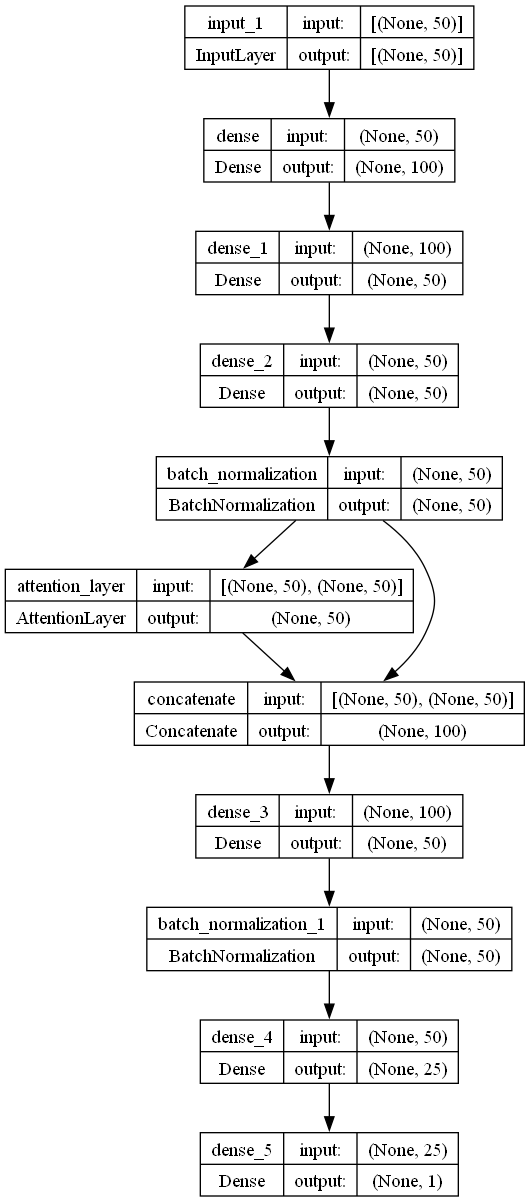

In [8]:
tf.keras.backend.clear_session()
# Define the attention layer
print("Number of Node: {}".format(features.shape[1]//2))
print("Number 2 of Node: {}".format(features.shape[1]//1.5))


class AttentionLayer(tf.keras.layers.Layer):
    def call(self, inputs, **kwargs):
        q, v = inputs
        attention = tf.keras.layers.Attention()([q, v])
        return attention

# Build the model
input_layer = Input(shape=(features.shape[1],))

# Traditional neural network part
x = layers.Dense(features.shape[1]*2, activation='relu')(input_layer)
x = layers.Dense(features.shape[1], activation='relu')(x) 
x = layers.Dense(features.shape[1], activation='relu')(x) 
x = layers.BatchNormalization()(x)
 
attention = AttentionLayer()([x, x]) 
x = layers.Concatenate()([x, attention])
x = layers.Dense(features.shape[1], activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(features.shape[1]//2, activation='relu')(x)
# Output layer
output_layer = layers.Dense(1, activation='sigmoid')(x)



model = tf.keras.Model(inputs=input_layer, outputs=output_layer) 
optimizer = AdamW(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', recall, precision, f1_score, auc])

# Display the model summary
#model.summary()


# Save the model architecture plot to a PNG file
picturePath = "{}Model_Architecture_{}.png".format(dataSetResultDirectory, dataSetName)
print(picturePath)

from tensorflow.keras.utils import plot_model
from IPython.display import Image 
plot_model(model, to_file=picturePath, show_shapes=True, show_layer_names=True) 


In [9]:
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 100)                  5100      ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 50)                   5050      ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 50)                   2550      ['dense_1[0][0]']             
                                                                                              

In [10]:
numberOfEpochs = 40
batchSizeOfTraining = 25
history = 0

history = model.fit(features, target, epochs=numberOfEpochs, batch_size=batchSizeOfTraining)

model2 = model




Epoch 1/40


2277/2277 [==============================] - 14s 4ms/step - loss: 0.2640 - accuracy: 0.8906 - recall: 0.9080 - precision: 0.8774 - f1_score: 0.6667 - auc: 0.9563
Epoch 2/40
2277/2277 [==============================] - 10s 4ms/step - loss: 0.2041 - accuracy: 0.9203 - recall: 0.9377 - precision: 0.9063 - f1_score: 0.6667 - auc: 0.9730
Epoch 3/40
2277/2277 [==============================] - 10s 5ms/step - loss: 0.1719 - accuracy: 0.9345 - recall: 0.9493 - precision: 0.9221 - f1_score: 0.6667 - auc: 0.9803
Epoch 4/40
2277/2277 [==============================] - 10s 5ms/step - loss: 0.1484 - accuracy: 0.9459 - recall: 0.9574 - precision: 0.9360 - f1_score: 0.6667 - auc: 0.9847
Epoch 5/40
2277/2277 [==============================] - 10s 5ms/step - loss: 0.1298 - accuracy: 0.9539 - recall: 0.9629 - precision: 0.9459 - f1_score: 0.6667 - auc: 0.9880
Epoch 6/40
2277/2277 [==============================] - 10s 4ms/step - loss: 0.1158 - accuracy: 0.9587 - recall: 0.9669 - precision: 

In [11]:

y_test_float64 = np.asarray(y_test).astype('float64').reshape((-1,1))  #data['CoronaryHeartDisease']
model_history = model2.fit(X_test_scaler, y_test_float64, epochs=2, batch_size=batchSizeOfTraining)

Epoch 1/2
570/570 [==============================] - 5s 9ms/step - loss: 0.2578 - accuracy: 0.8999 - recall: 0.9081 - precision: 0.8935 - f1_score: 0.6667 - auc: 0.9592
Epoch 2/2
570/570 [==============================] - 5s 8ms/step - loss: 0.1423 - accuracy: 0.9488 - recall: 0.9605 - precision: 0.9385 - f1_score: 0.6667 - auc: 0.9857


In [12]:
# Evaluate the model using the evaluate method
y_test_float64 = np.asarray(y_test).astype('float64').reshape((-1,1))  #data['CoronaryHeartDisease']

loss, accuracy, recall_value, precision_value, f1_score_value, auc_value = model2.evaluate(X_test_scaler, y_test_float64)

# Print the results
print('Test loss: {}'.format(loss*100))
print('Test accuracy: {}'.format(accuracy*100))
print('Test recall: {}'.format(recall_value*100))
print('Test precision: {}'.format(precision_value*100))
print('Test F1 score: {}'.format(f1_score_value*100))
print('Test AUC: {}'.format(auc_value*100))


picturePath = "{}Model_Evaluation_{}_{}_Epoch_{}.png".format(dataSetResultDirectory, "Testing_Accuracy", dataSetName, numberOfEpochs)


445/445 [==============================] - 5s 6ms/step - loss: 0.0906 - accuracy: 0.9721 - recall: 0.9793 - precision: 0.9654 - f1_score: 0.6668 - auc: 0.9939
Test loss: 9.056360274553299
Test accuracy: 97.20972776412964
Test recall: 97.93365001678467
Test precision: 96.53595685958862
Test F1 score: [66.68229]
Test AUC: 99.39255118370056


445/445 [==============================] - 3s 6ms/step
MLP with Attention layer Confusion Matrix saved:: path: ./DatasetResults_MLP_with_AttentionLayers_CardiacPrediction/Model_Evaluation_MLP with Attention layer_CardiacPrediction_(37079, 51)_Epoch_40.png


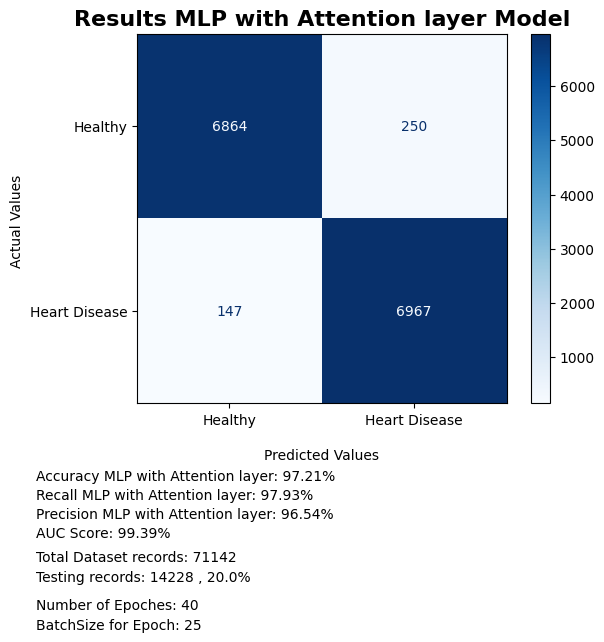

In [13]:
threshold = 0.5  # Adjust the threshold as needed
binary_predictions = (model2.predict(X_test_scaler) > threshold).astype(int)

cm = confusion_matrix(y_test_float64, binary_predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Heart Disease'])

display.plot(cmap=plt.cm.Blues, values_format=".4g") 


method = "MLP with Attention layer"
display.ax_.set_title("Results {} Model".format(method),fontsize=16, fontweight='bold')
display.ax_.set_xlabel('\nPredicted Values')
display.ax_.set_ylabel('Actual Values ')

accuracyString ="Accuracy {}: {:.2f}%".format(method, accuracy*100.0 ) 
recallString =  'Recall {}: {:.2f}%'.format(method, recall_value* 100.0)
precisionString = 'Precision {}: {:.2f}%'.format(method, precision_value * 100.0) 
#f1String = "F1 Score: {:.2f}".format(f1_score_value * 100.0)
featureListString = "AUC Score: {:.2f}%".format(auc_value * 100.0)
totaldataSetString = "Total Dataset records: {}".format((len(features)+len(X_test_scaler)))
testingdataSetString = "Testing records: {} , {:.1f}%".format(len(X_test_scaler), ( ( len(X_test_scaler) / (len(features)+len(X_test_scaler)) )*100.0  ))
numberOfEpochsString = "Number of Epoches: {}".format(numberOfEpochs)
batchSizeOfTrainingString = "BatchSize for Epoch: {}".format(batchSizeOfTraining)

display.figure_.text(0.010, -0.05,  accuracyString, horizontalalignment='left', wrap=False )  
display.figure_.text(0.010, -0.09,  recallString, horizontalalignment='left', wrap=False )      
display.figure_.text(0.010, -0.13,  precisionString, horizontalalignment='left', wrap=False ) 
display.figure_.text(0.010, -0.17,  featureListString, horizontalalignment='left', wrap=False ) 
display.figure_.text(0.010, -0.22,  totaldataSetString, horizontalalignment='left', wrap=False ) 
display.figure_.text(0.010, -0.26,  testingdataSetString, horizontalalignment='left', wrap=False ) 
display.figure_.text(0.010, -0.32,  numberOfEpochsString, horizontalalignment='left', wrap=False ) 
display.figure_.text(0.010, -0.36,  batchSizeOfTrainingString, horizontalalignment='left', wrap=False ) 
 
picturePath = "{}Model_Evaluation_{}_{}_Epoch_{}.png".format(dataSetResultDirectory, method, dataSetName, numberOfEpochs)
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
print("{} Confusion Matrix saved:: path: {}".format(method, picturePath))

mplot.show()
mplot.close()


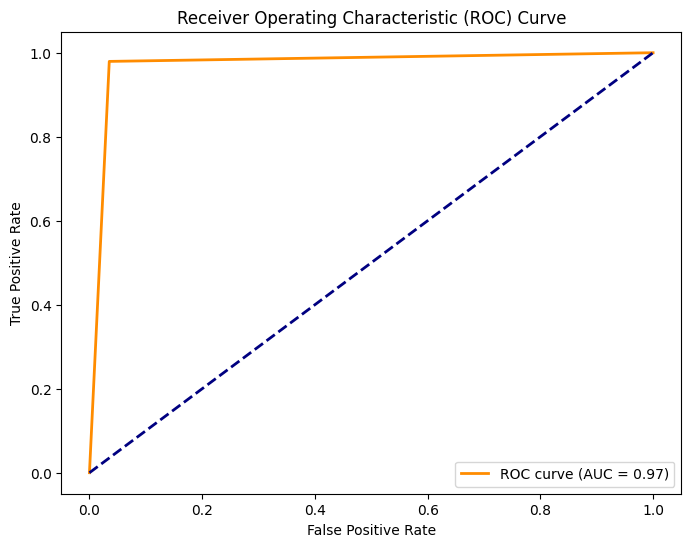

In [14]:
# Calculate AUC
auc_score = roc_auc_score(y_test, binary_predictions)
# Calculate ROC Curve
fpr, tpr, _ = roc_curve(y_test, binary_predictions)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

picturePath = "{}Model_Evaluation_ROC_{}_{}_Epoch_{}.png".format(dataSetResultDirectory, method, dataSetName, numberOfEpochs)
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')

plt.show()
plt.close()




In [15]:
import matplotlib.pyplot as plt

# Sample data for illustration purposes
history = {'accuracy': [0.6, 0.7, 0.8, 0.9],
           'loss': [0.5, 0.4, 0.3, 0.2],
           'precision': [0.7, 0.8, 0.85, 0.9]}

# Plot accuracy
plt.plot(model_history.history['accuracy'], label='Accuracy')

# Plot precision
plt.plot(model_history.history['precision'], label='Precision' )

# Plot loss
plt.plot(model_history.history['loss'], label='Loss')

# Set plot labels and title
plt.title('Training Evaluation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metrics Value')

# Add legend
plt.legend()

picturePath = "{}Model_Training_Evaluation_{}_{}_Epoch_{}.png".format(dataSetResultDirectory, method, dataSetName, numberOfEpochs)
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')

plt.show()
plt.close()


In [16]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train accuracy')
#plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.title('MLP+AttentionLayer Evaluation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Add additional metrics and adjust label positions
metrics = ['loss', 'recall', 'precision', 'f1_score', 'auc']
for i, metric in enumerate(metrics):
    plt.plot(model_history.history[metric], label=metric.capitalize())
    y_offset = (i - 2) * 0.1  # Adjust based on desired spacing
    plt.text(1, 1 - y_offset, metric.capitalize(), verticalalignment='top', ha='right', transform=plt.gca().transAxes)

# Adjust layout and legend
plt.subplots_adjust(right=0.75)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Save and clear plot
picturePath = "{}Result_ModelEvaluation_{}_{}.png".format(dataSetResultDirectory, "MLP+AttentionLayer Model", dataSetName)
plt.savefig(picturePath, dpi=300, bbox_inches='tight')
#plt.show()
plt.close()


Total Features: 56914 -> Selected for SHAP:: 5691
Total Test: 14228 -> Selected for SHAP:: 1422


PermutationExplainer explainer: 1423it [21:40,  1.09it/s]                          


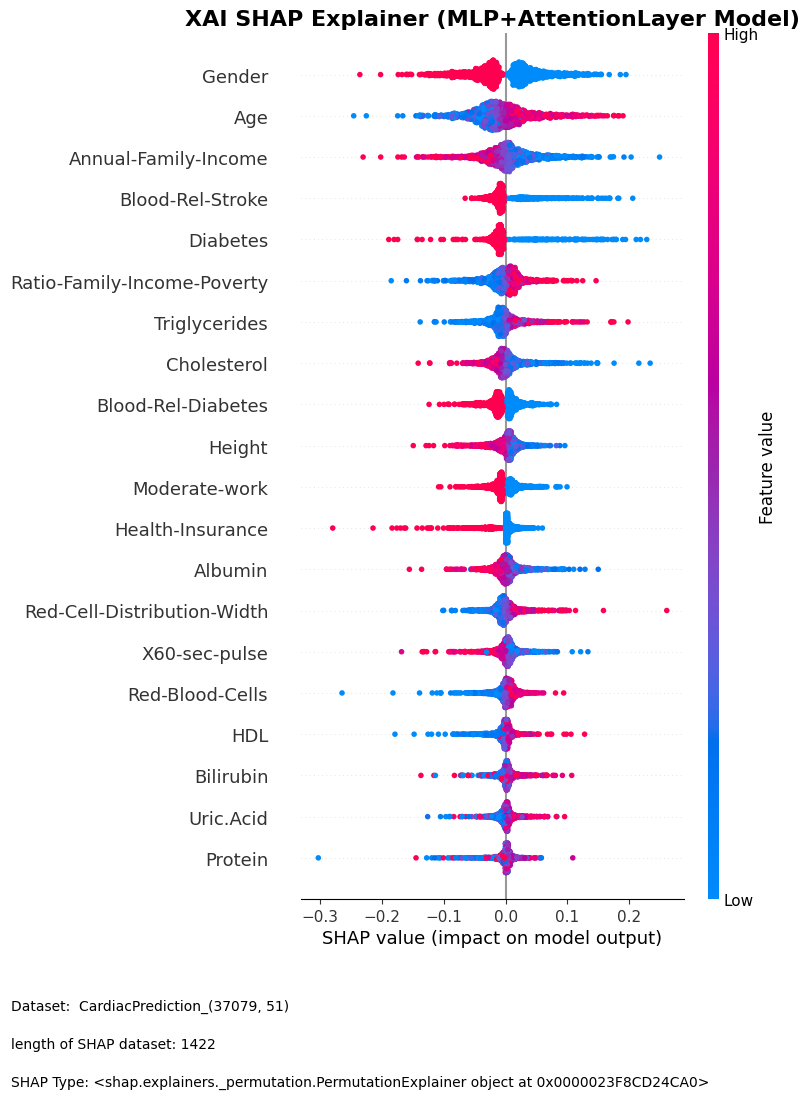

In [18]:
percentage = 0.10
numberOfFeatures = int(len(features) *percentage)
print("Total Features: {} -> Selected for SHAP:: {}".format(len(features), numberOfFeatures))
featuresForShap = X_train.columns #features[0:numberOfFeatures]
#print(" Features Name: {}".format(  featuresForShap))

numberOftest = int(len(X_test_scaler) * percentage)
print("Total Test: {} -> Selected for SHAP:: {}".format(len(X_test_scaler), numberOftest))
testForShap = X_test_scaler[0:len(featuresForShap)]
testForShap = X_test_scaler[0:numberOftest]
#print(" testForShap Name: {}".format(  testForShap))


shap_explainer = shap.Explainer(model, feature_names=featuresForShap, masker=shap.maskers.Independent(data=testForShap)) 
shap_values = shap_explainer.shap_values(testForShap)  

def makeSHAPreport(method, model):
    shap.summary_plot(shap_values, testForShap, featuresForShap, show=False)
    ax = mplot.gca() 
    ax.set_title("XAI SHAP Explainer ({} Model)".format(method) ,fontsize=16, fontweight='bold')     

    dataSetString = "Dataset:  {}".format(dataSetName)
    testingDatasetString ="length of SHAP dataset: {}".format(len(testForShap))
    shapTypeString ="SHAP Type: {}".format(repr(shap_explainer)) 
    ax.figure.text(0.020, -0.05,  dataSetString, horizontalalignment='left', wrap=False )  
    ax.figure.text(0.020, -0.09,  testingDatasetString, horizontalalignment='left', wrap=False )   
    ax.figure.text(0.020, -0.13,  shapTypeString, horizontalalignment='left', wrap=False )   

    picturePath = "{}XAI_SHAP_Explainer_{}_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
    mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
    #mplot.savefig(picturePath,  dpi=300) 
    mplot.show()
    #os.startfile(picturePath)
    mplot.close()


makeSHAPreport("MLP+AttentionLayer", model)

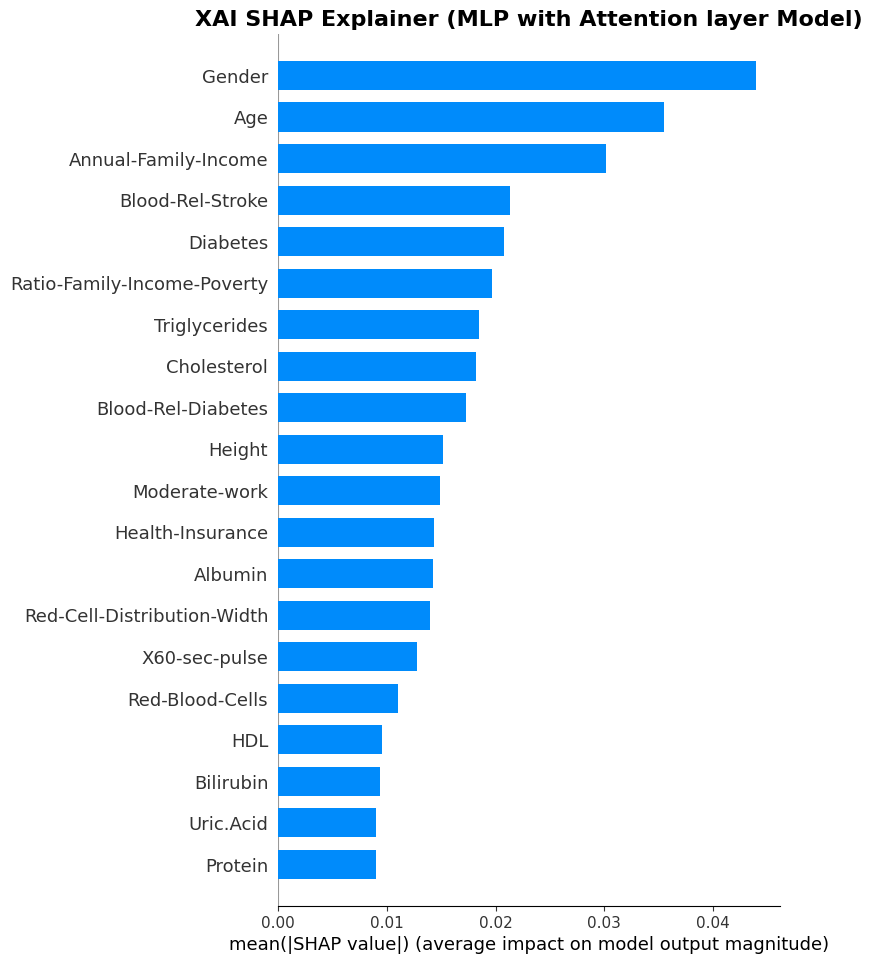

In [21]:
shap.summary_plot(shap_values, testForShap, featuresForShap, plot_type='bar', show=False)
ax = mplot.gca() 
ax.set_title("XAI SHAP Explainer ({} Model)".format(method) ,fontsize=16, fontweight='bold')    

'''
dataSetString = "Dataset:  {}".format(dataSetName)
testingDatasetString ="length of Testing Set: {}".format(len(testForShap))
shapTypeString ="SHAP Type: {}".format(repr(shap_explainer)) 
ax.figure.text(0.020, -0.05,  dataSetString, horizontalalignment='left', wrap=False )  
ax.figure.text(0.020, -0.09,  testingDatasetString, horizontalalignment='left', wrap=False )   
ax.figure.text(0.020, -0.13,  shapTypeString, horizontalalignment='left', wrap=False )   
'''

picturePath = "{}XAI_SHAP_Explainer_BAR_{}_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
mplot.show()
mplot.close()

# Print or use the te

In [24]:
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Concatenate


# Assuming 'features' is your input data
X_train_forLime, X_test_forLime, y_train_forLime, y_test_forLime = train_test_split(features, target, test_size=0.2, random_state=42)
 
# Wrap the TensorFlow model for LIME
class LimeModelWrapper:
    def __init__(self, model, feature_names):
        self.model = model
        self.feature_names = feature_names

    '''
    def predict_proba(self, instances):
        # Ensure the model outputs probabilities
        raw_predictions = self.model.predict(instances)
        probabilities = tf.nn.softmax(raw_predictions, axis=-1).numpy()
        return probabilities.tolist() 
    '''
    def predict_proba(self, instances):
        # Ensure the model outputs probabilities
        instances = np.array(instances)  # Convert to NumPy array
        #if len(instances.shape) == 1: instances = instances.reshape(1, -1)  # Reshape to 2D if it's 1D
        raw_predictions = self.model.predict(instances)
        probabilities = tf.nn.softmax(raw_predictions, axis=-1).numpy()
        return probabilities   # Convert the array to a list



lime_model = LimeModelWrapper(model, featuresForShap)


#print("featuresForShap: {}".format(featuresForShap))

# Instantiate LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer( np.array(X_train_forLime), mode='classification', feature_names=featuresForShap, verbose=True, class_names=["Healthy", "Heart Patient"] ) 

# Generate explanations for each testing instance
instance = X_test_forLime
num_instances = 50 # int(len(X_test_forLime) / 4)
print("num_instances: {}".format(num_instances))

explanations = [] 


for i in range(num_instances):
    instan = instance[i]
    #print(instan.dtype)
    #print(instan.shape)
    #print("Instance {}: {}".format(i, instan))  # Add this line to print the instance
    prediction = lime_model.predict_proba([instan])
    print("Model Prediction for Instance {}: {}".format(i, prediction))  # Add this line to print the model prediction
    explanation = explainer.explain_instance(
        instan,
        lime_model.predict_proba,
        num_features=len(featuresForShap),
        top_labels=1,
        labels=[1],
        num_samples=1000  # Adjust the number of samples here
    )
    explanations.append(explanation)
    print("Explanation Map for Instance {}: {}".format(i, explanation.as_map())) 




num_instances: 50
1/1 [==============================] - 0s 41ms/step
Model Prediction for Instance 0: [[1.]]
32/32 [==============================] - 0s 3ms/step
Intercept 1.0
Prediction_local [1.]
Right: 1.0
Explanation Map for Instance 0: {0: [(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0), (9, 0.0), (10, 0.0), (11, 0.0), (12, 0.0), (13, 0.0), (14, 0.0), (15, 0.0), (16, 0.0), (17, 0.0), (18, 0.0), (19, 0.0), (20, 0.0), (21, 0.0), (22, 0.0), (23, 0.0), (24, 0.0), (25, 0.0), (26, 0.0), (27, 0.0), (28, 0.0), (29, 0.0), (30, 0.0), (31, 0.0), (32, 0.0), (33, 0.0), (34, 0.0), (35, 0.0), (36, 0.0), (37, 0.0), (38, 0.0), (39, 0.0), (40, 0.0), (41, 0.0), (42, 0.0), (43, 0.0), (44, 0.0), (45, 0.0), (46, 0.0), (47, 0.0), (48, 0.0), (49, 0.0)]}
1/1 [==============================] - 0s 34ms/step
Model Prediction for Instance 1: [[1.]]
32/32 [==============================] - 0s 3ms/step
Intercept 1.0
Prediction_local [1.]
Right: 1.0
Explanation Map for 

Feature Importances: []


feature_list:Index(['SEQN', 'Gender', 'Age', 'Annual-Family-Income',
       'Ratio-Family-Income-Poverty', 'X60-sec-pulse', 'Systolic', 'Diastolic',
       'Weight', 'Height', 'Body-Mass-Index', 'White-Blood-Cells',
       'Lymphocyte', 'Monocyte', 'Eosinophils', 'Basophils', 'Red-Blood-Cells',
       'Hemoglobin', 'Mean-Cell-Vol', 'Mean-Cell-Hgb-Conc.',
       'Mean-cell-Hemoglobin', 'Platelet-count', 'Mean-Platelet-Vol',
       'Segmented-Neutrophils', 'Hematocrit', 'Red-Cell-Distribution-Width',
       'Albumin', 'ALP', 'AST', 'ALT', 'Cholesterol', 'Creatinine', 'Glucose',
       'GGT', 'Iron', 'LDH', 'Phosphorus', 'Bilirubin', 'Protein', 'Uric.Acid',
       'Triglycerides', 'Total-Cholesterol', 'HDL', 'Glycohemoglobin',
       'Vigorous-work', 'Moderate-work', 'Health-Insurance', 'Diabetes',
       'Blood-Rel-Diabetes', 'Blood-Rel-Stroke'],
      dtype='object')
averageF:[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

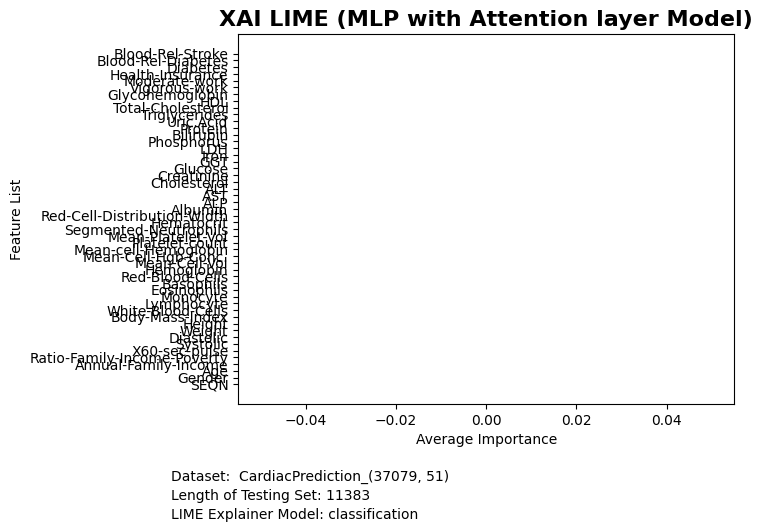

In [25]:
feature_importances = [exp.as_map()[1] for exp in explanations if 1 in exp.as_map()]
print("Feature Importances: {}".format(feature_importances))

# Check if the feature_importances list is not empty
if feature_importances: 
    feature_importances = feature_importances[0]
else: 
    feature_importances = [(i, 0.0) for i in range(len(featuresForShap))]

averageF = [singleFeature[1] for singleFeature in feature_importances]


print("\n\nfeature_list:{}".format(featuresForShap))
print("averageF:{} \n\n".format(averageF))


# Plot the feature importances
fig, ax = plt.subplots()
ax.barh(featuresForShap, averageF)
ax.set_ylabel('Feature List')
ax.set_xlabel('Average Importance')
ax.set_title("XAI LIME ({} Model)".format(method), fontsize=16, fontweight='bold')

# Additional information
dataSetString = "Dataset:  {}".format(dataSetName)
testingDatasetString = "Length of Testing Set: {}".format(len(X_test_forLime))
explainerModelString = "LIME Explainer Model: {}".format(explainer.mode)
ax.figure.text(0.020, -0.05, dataSetString, horizontalalignment='left', wrap=False)
ax.figure.text(0.020, -0.09, testingDatasetString, horizontalalignment='left', wrap=False)
ax.figure.text(0.020, -0.13, explainerModelString, horizontalalignment='left', wrap=False)

# Save and show the plot
picturePath = "{}XAI_LIME_2_{}_{}.png".format(dataSetResultDirectory, method, dataSetName)
plt.savefig(picturePath, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [26]:
import datetime
currentDateTime = datetime.datetime.now() 
currentDateTime = currentDateTime.strftime("%Y%m%d %H%M") 
modelPath = "{}model02_trained_{}_{}_{}percent.model".format(dataSetResultDirectory, dataSetName, currentDateTime, accuracy)
print(modelPath)
model2.save(modelPath)

./DatasetResults_MLP_with_AttentionLayers_CardiacPrediction/model02_trained_CardiacPrediction_(37079, 51)_20231228 1312_0.9720972776412964percent.model
INFO:tensorflow:Assets written to: ./DatasetResults_MLP_with_AttentionLayers_CardiacPrediction/model02_trained_CardiacPrediction_(37079, 51)_20231228 1312_0.9720972776412964percent.model\assets


INFO:tensorflow:Assets written to: ./DatasetResults_MLP_with_AttentionLayers_CardiacPrediction/model02_trained_CardiacPrediction_(37079, 51)_20231228 1312_0.9720972776412964percent.model\assets
